In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats
import glob
import os
from natsort import natsorted
import random
plt.rcParams['figure.figsize'] = [10, 5]

In [16]:
path = 'viz_predictions/new'
im_num = '777'

img = cv2.imread(path+'/gray/'+im_num+'.jpg', 0) #Grayscale image
img_rgb = cv2.imread(path+'/rgb/'+im_num+'.jpg', 1) #RGB image
keypoints = np.load(path+'/keypoints/'+im_num+'.npy') #hand keypoint numpy array
pose = np.load(path+'/pose/'+im_num+'.npy') #pose keypoint numpy array

print('Shape of keypoints is {}'.format(keypoints.shape))
print('Array is of shape (No of hands, No of people, hand keypoints, 3)')
print('Final dimension is: y coordinate, x coordinate and confidence')
print('Pose indices 3,4,6 and 7 correspond to Right elbow, Right wrist, Left elbow and Left wrist')

handloc = keypoints[:,:,:,0:2].astype(int)

#Dictionary of keypoinnt and index
part_loc = {'left':0, 'right':1, 'right_elbow':3, 'right_wrist':4, 'left_elbow':6, 'left_wrist':7}

Shape of keypoints is (2, 4, 21, 3)
Array is of shape (No of hands, No of people, hand keypoints, 3)
Final dimension is: y coordinate, x coordinate and confidence
Pose indices 3,4,6 and 7 correspond to Right elbow, Right wrist, Left elbow and Left wrist


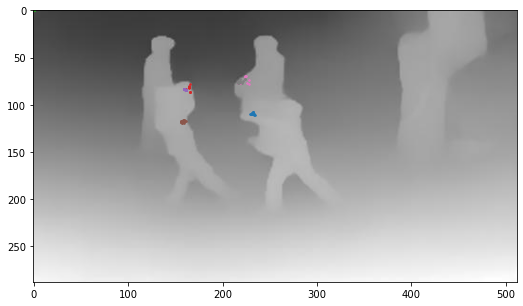

In [17]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
num_ppl = handloc.shape[1]

for pers in range(0,num_ppl):
    plt.scatter(handloc[0][pers][:,0], handloc[0][pers][:,1], s=2.5)
    plt.scatter(handloc[1][pers][:,0], handloc[1][pers][:,1], s=2.5)

# hands3D = handloc
# plt.savefig('test.jpg')

In [18]:
#Extracting depth values of each hand named as 'person_number___left/right'
hands3D = np.zeros(keypoints.shape)

for pers in range(num_ppl):
    for hand in range(hands3D.shape[0]):
        depth = img[handloc[hand,pers,:,1], handloc[hand,pers,:,0]] 
        hands3D[hand,pers,:,2] = depth
    hands3D[:,pers,:,0:2] = handloc[:,pers,:,:]
    hands3D = hands3D.astype(int)

In [20]:
#Adjust handkeypoint depth using elbow and wrist depth values
hands3D_ = hands3D.copy()

rightarm = pose[:, 3:4, 0:2].astype(int)
leftarm = pose[:, 6:7, 0:2].astype(int)

Rarm_depth = img[rightarm[:,:,1], rightarm[:,:,0]]
Larm_depth = img[leftarm[:,:,1], leftarm[:,:,0]]
Rdelta = Rarm_depth.mean(axis=1).astype(int).reshape(pose.shape[0],1)
Ldelta = Larm_depth.mean(axis=1).astype(int).reshape(pose.shape[0],1)

hands3D_[part_loc['left'],:,:,2] = (hands3D[part_loc['left'],:,:,2] + Ldelta)/2
hands3D_[part_loc['right'],:,:,2] = (hands3D[part_loc['right'],:,:,2] + Rdelta)/2

hands3D = hands3D_.copy()

In [21]:
start_pt =[]
end_pt = []

for i in range(hands3D.shape[1]):
    for j in range(hands3D.shape[1]):
        if i != j:
            diff1 = abs(hands3D[0,i,:,:] - hands3D[0,j,:,:])
            eucdis1 = np.linalg.norm(diff1, axis=1)
            mode1, count1 = stats.mode(eucdis1)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis1) < 180 and sum(eucdis1) != 0:
                print('Handshake1 detected. RUN!!!')
                xs1 = np.argmin(np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1])))
                ys1 = np.argmin(np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0])))
                xe1 = np.argmax(np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1])))
                ye1 = np.argmax(np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0])))
                start1 = (np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0]))[ys1], np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1]))[xs1])
                end1 = (np.hstack((hands3D[0,i,:,0], hands3D[0,j,:,0]))[ye1], np.hstack((hands3D[0,i,:,1], hands3D[0,j,:,1]))[xe1])
                start_pt.append(start1)
                end_pt.append(end1)

            diff2 = abs(hands3D[0,i,:,:] - hands3D[1,j,:,:])
            eucdis2 = np.linalg.norm(diff2, axis=1)
            mode2, count2 = stats.mode(eucdis2)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis2) < 180 and sum(eucdis2) != 0:
                print(sum(eucdis2))
                print('Handshake2 detected. RUN!!!')
                xs2 = np.argmin(np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1])))
                ys2 = np.argmin(np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0])))
                xe2 = np.argmax(np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1])))
                ye2 = np.argmax(np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0])))
                start2 = (np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0]))[ys2], np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1]))[xs2])
                end2 = (np.hstack((hands3D[0,i,:,0], hands3D[1,j,:,0]))[ye2], np.hstack((hands3D[0,i,:,1], hands3D[1,j,:,1]))[xe2])
                start_pt.append(start2)
                end_pt.append(end2)

            diff3 = abs(hands3D[1,i,:,:] - hands3D[0,j,:,:])
            eucdis3 = np.linalg.norm(diff3, axis=1)
            mode3, count3 = stats.mode(eucdis3)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis3) < 180 and sum(eucdis3) != 0:
                print('Handshake3 detected. RUN!!!')
                xs3 = np.argmin(np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1])))
                ys3 = np.argmin(np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0])))
                xe3 = np.argmax(np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1])))
                ye3 = np.argmax(np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0])))
                start3 = (np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0]))[ys3], np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1]))[xs3])
                end3 = (np.hstack((hands3D[1,i,:,0], hands3D[0,j,:,0]))[ye3], np.hstack((hands3D[1,i,:,1], hands3D[0,j,:,1]))[xe3])
                start_pt.append(start3)
                end_pt.append(end3)

            diff4 = abs(hands3D[1,i,:,:] - hands3D[1,j,:,:])
            eucdis4 = np.linalg.norm(diff4, axis=1)
            mode4, count4 = stats.mode(eucdis4)

            #Detect if Handshake and find min and max coordinates for bounding box and append to lisr
            if sum(eucdis4) < 180 and sum(eucdis4) != 0:
                print('Handshake4 detected. RUN!!!')
                xs4 = np.argmin(np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1])))
                ys4 = np.argmin(np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0])))
                xe4 = np.argmax(np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1])))
                ye4 = np.argmax(np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0])))
                start4 = (np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0]))[ys4], np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1]))[xs4])
                end4 = (np.hstack((hands3D[1,i,:,0], hands3D[1,j,:,0]))[ye4], np.hstack((hands3D[1,i,:,1], hands3D[1,j,:,1]))[xe4])
                start_pt.append(start4)
                end_pt.append(end4)

#         mode = np.array([mode1,mode2,mode3,mode4])
num_cont = len(start_pt)
print("Number of handshakes = {}".format(num_cont/2))

print(start_pt, end_pt)

Number of handshakes = 0.0
[] []


(array([2., 1., 4., 2., 2., 5., 1., 1., 2., 1.]),
 array([71.39327699, 72.36628558, 73.33929417, 74.31230275, 75.28531134,
        76.25831992, 77.23132851, 78.20433709, 79.17734568, 80.15035426,
        81.12336285]),
 <BarContainer object of 10 artists>)

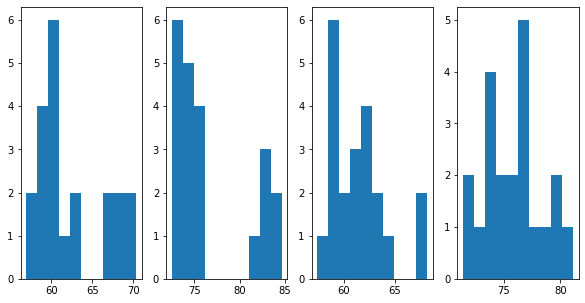

In [7]:
#Histogram of 2 norm for the 21 keypoints
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.hist(eucdis1)
ax2.hist(eucdis2)
ax3.hist(eucdis3)
ax4.hist(eucdis4)


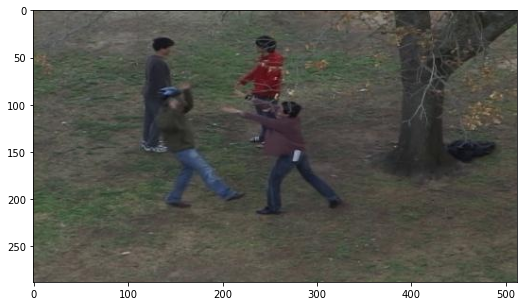

In [8]:
#Plot bounding box
img_rgb_ = img_rgb.copy()
for contact in range(len(start_pt)):
    cv2.rectangle(img_rgb_, start_pt[contact], end_pt[contact],[0,0,255], 2)
plt.imshow(cv2.cvtColor(img_rgb_,cv2.COLOR_BGR2RGB))
plt.show()

In [297]:
from mpl_toolkits.mplot3d import Axes3D

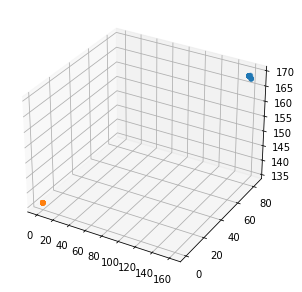

In [298]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Axes3D.scatter(ax,hands3D[0,2,:,0], hands3D[0,2,:,1], hands3D[0,2,:,2], zdir='z')
Axes3D.scatter(ax,hands3D[1,0,:,0], hands3D[1,0,:,1], hands3D[1,0,:,2], zdir='z')


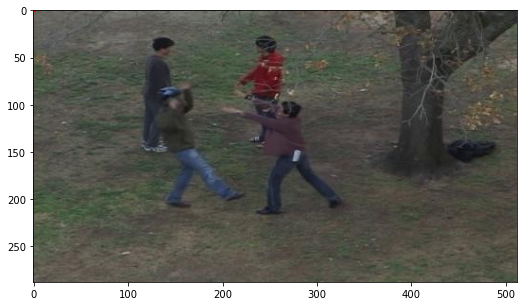

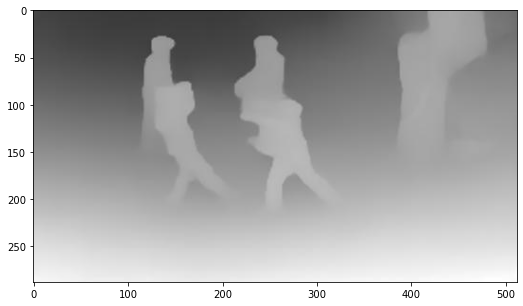

In [299]:
# for idx in [0,1]:
#     plt.scatter(handloc[0][idx][:,0], handloc[0][idx][:,1], s=2)
# #     plt.scatter(handloc[1][idx][:,0], handloc[1][idx][:,1], s=2)
    
plt.scatter(pose[1][6][0], pose[1][6][1], s=3, edgecolors='yellow')
plt.scatter(hands3D[0][1][:,0], hands3D[0][1][:,1], s=3, edgecolors='red')

plt.imshow(cv2.cvtColor(img_rgb,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()